#### task

input: libraries (names, lat and long), time (for radius), census tract data frame (geoids, polygons)
to do: 
- (nested for loop) 
    - loop through libraries 
     - radii polygons -- put onto dataframe
        - for each ct loop for intersections
            if ct intersects
            - get intersection of the radii
            - get area of intersection
            - using area of current ct calculate percent
            - add ct and % coverage to a dictionary with as a key, value pair (ct, %)
            - on ct datframe col score = col score +=
      
output: overlapping census tracts and proportion covered for each radius (total coverage proportion for each census tract)

In [1]:
#imports

from api.mapbox_api import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium
from pyproj import Geod

In [2]:
branchInfo = gpd.read_file('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
api = MapboxAPI()

In [4]:
# setting up data frames
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])

censusTracts = populationDemographics[['geoid','geometry','qualifying name']]
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )
#censusTracts.head(5)

In [5]:
censusAreas = []
geod=Geod(ellps='WGS84')

for index, row in censusTracts.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area*-1
    censusAreas.append(poly_area)
censusTracts['calculated area'] = censusAreas

#censusTracts.head()

In [6]:
branchInfo

,BRANCH,LOCATION,geometry
0,Albany Park,"(41.97557881655979, -87.71361314512697)",None
1,Altgeld,"(41.65719847558056, -87.59883829075173)",None
2,Archer Heights,"(41.80110836194246, -87.72648385568911)",None
3,Austin,"(41.88917312206642, -87.7658203582574)",None
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)",None
...,...,...,...
77,West Pullman,"(41.67790647382097, -87.6431683153105)",None
78,West Town,"(41.89594730478282, -87.66829305460979)",None
79,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)",None
80,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)",None


In [7]:
censusTracts['score'] = 0.0
censusTracts.head()

,geoid,qualifying name,geometry,calculated area,score
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",1.081697e+00,0.0
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",3.526503e+05,0.0
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.69127, -87.71937 41.691...",2.782659e+06,0.0
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.72043 41.69857, -87.72007 41.698...",1.319688e+06,0.0
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.72075 41.70204, -87.72075 ...",1.577396e+01,0.0


In [8]:
def check(polygon1, df, geoname, dictionary):
    
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'calculated area']
            #print(propOverlap)
            dictionary[df.loc[i, 'geoid']] = propOverlap
    return dictionary
   

In [9]:
branchInfo = branchInfo.set_crs('EPSG:4326')
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


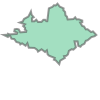

In [10]:
api_response =  api.get_data((branchInfo.loc[0,'LATITUDE'],branchInfo.loc[0,'LONGITUDE']), 5)

branchInfo.loc[0,'geometry'] = shape(api_response)
branchInfo.loc[0,'geometry']

In [11]:
diction = {}
dicheck = check(branchInfo.loc[0,'geometry'], censusTracts, 'geometry', diction)

In [12]:
dicheck

{17031140800: 0.10910496440467443,
 17031160501: 0.06956750011480983,
 17031140702: 0.7670524619471873,
 17031140601: 0.09984736045965159,
 17031140602: 0.2901156246524094,
 17031140701: 1.0,
 17031140301: 0.9985859807679166,
 17031140200: 1.0,
 17031140100: 0.8813585234481817,
 17031140302: 1.0,
 17031040300: 0.9094523372251797,
 17031831800: 1.0,
 17031130300: 0.9299625828246706,
 17031020701: 0.15999129328715705,
 17031130100: 0.10619982820961861,
 17031140400: 0.3183246130218854,
 17031130200: 0.3313820277738053,
 17031040201: 0.2949481552290385,
 17031040202: 0.15262759917847812}

In [18]:
branchInfo = branchInfo.set_crs('EPSG:4326')
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])
branchInfo.head()

censusTracts['score'] = 0.0
branchInfo['dictionary'] = ''
for i in range(len(branchInfo)):
    dictionary = {}
    api_response =  api.get_data((branchInfo.loc[i,'LATITUDE'],branchInfo.loc[i,'LONGITUDE']), 5)
    branchInfo.loc[i,'geometry'] = shape(api_response)
    dictionary = check(branchInfo.loc[i,'geometry'],censusTracts,'geometry', dictionary)
    branchInfo.loc[i,'dictionary']= [dictionary]
    
    for i in range(len(censusTracts)):
   
        if dictionary.get(censusTracts.loc[i, 'geoid']) != None:
            score = censusTracts.loc[i, 'score']
            censusTracts.loc[i, 'score'] = score + dictionary.get(censusTracts.loc[i, 'geoid'])
  
          

In [19]:
branchInfo

,BRANCH,LOCATION,geometry,LATITUDE,LONGITUDE,dictionary
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71361 41.99322, -87.71461 41.992...",41.975579,-87.713613,"[{17031140800: 0.10910496440467443, 1703116050..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59684 41.69523, -87.59691 41.693...",41.657198,-87.598838,"[{17031825801: 0.1615035489776389, 17031826401..."
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72348 41.81848, -87.72559 41.816...",41.801108,-87.726484,"[{17031650200: 0.0254912176417698, 17031650100..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76482 41.90631, -87.76582 41.906...",41.889173,-87.765820,"[{17031252101: 0.39452842303857544, 1703181300..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.78829 41.96819, -87.78833 41.962...",41.953123,-87.779285,"[{17031190402: 0.022557937206714188, 170311904..."
...,...,...,...,...,...,...
77,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.64217 41.70308, -87.64351 41.701...",41.677906,-87.643168,"[{17031821402: 0.990325261989984, 17031821200:..."
78,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66729 41.91073, -87.66881 41.909...",41.895947,-87.668293,"[{17031280100: 0.001197490335336308, 170318381..."
79,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.63095 41.78607, -87.63108 41.779...",41.751018,-87.614951,"[{17031490200: 0.006124736067597431, 170314409..."
80,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.74373, -87.64405 41.744...",41.720695,-87.643048,"[{17031750500: 0.002029252118561393, 170317506..."


In [16]:
for i in range(len(censusTracts)):
    dictionary = branchInfo.loc[0,'dictionary'][0]
    if dictionary.get(censusTracts.loc[i, 'geoid']) != None:
        score = censusTracts.loc[i, 'score']
        #geoid = censusTracts.loc[i, 'geoid']
        
        censusTracts.loc[i, 'score'] = score + dictionary.get(censusTracts.loc[i, 'geoid'])
     

In [20]:
censusTracts.sort_values(by = 'score', ascending = False)

,geoid,qualifying name,geometry,calculated area,score
322,17031340600,"Census Tract 3406, Cook County, Illinois","POLYGON ((-87.63625 41.83088, -87.63623 41.830...",4.965761e+05,3.656036
323,17031351500,"Census Tract 3515, Cook County, Illinois","POLYGON ((-87.62907 41.82742, -87.62904 41.827...",1.662212e+05,3.561942
320,17031380600,"Census Tract 3806, Cook County, Illinois","POLYGON ((-87.62931 41.82368, -87.62928 41.823...",8.388936e+05,3.425128
377,17031832900,"Census Tract 8329, Cook County, Illinois","POLYGON ((-87.66666 41.87635, -87.66657 41.876...",4.045824e+05,3.159490
348,17031340500,"Census Tract 3405, Cook County, Illinois","POLYGON ((-87.63637 41.83453, -87.63634 41.834...",4.354491e+05,3.147072
...,...,...,...,...,...
816,17031980000,"Census Tract 9800, Cook County, Illinois","MULTIPOLYGON (((-87.93505 42.00582, -87.93484 ...",1.902470e+07,0.000000
817,17031770500,"Census Tract 7705, Cook County, Illinois","MULTIPOLYGON (((-87.92056 42.00483, -87.92061 ...",1.799139e+05,0.000000
818,17031770602,"Census Tract 7706.02, Cook County, Illinois","POLYGON ((-87.90416 42.00363, -87.90424 42.003...",6.839449e+05,0.000000
820,17031807600,"Census Tract 8076, Cook County, Illinois","POLYGON ((-87.70867 42.01896, -87.70867 42.018...",1.930083e+04,0.000000


Text(0.5, 1.0, 'Percent of Coverage')

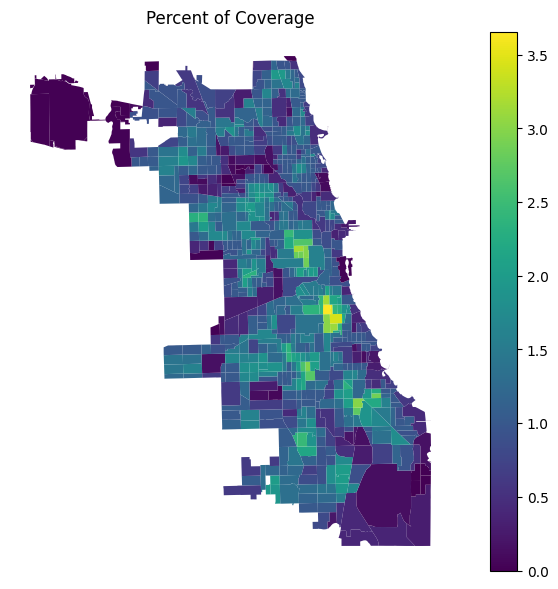

In [24]:
ax = censusTracts.plot(column = 'score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")